In [22]:
import os
import sys
import math
import pandas as pd
import numpy as np
from hmmlearn import hmm
np.random.seed(42)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from IPython.core.pylabtools import figsize
figsize(16, 6)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import logging
import itertools
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(100)

In [3]:
Z

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 2, 2, 0, 0, 0, 1, 1, 1, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [5]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
remodel.fit(X)  
Z2 = remodel.predict(X)

In [6]:
Z2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0,
       2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2,
       1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### multiple sequences

In [7]:
X1 = [[0.5], [1.0], [-1.0], [0.42], [0.24]]
X2 = [[2.4], [4.2], [0.5], [-0.24]]

In [8]:
X = np.concatenate([X1, X2])
lengths = [len(X1), len(X2)]

In [9]:
hmm.GaussianHMM(n_components=3).fit(X, lengths) 

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [10]:
Z3 = remodel.predict(X)
Z3

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Complex Sequence

In [2]:
def sum_of_sines(number_of_steps, d_theta, skip_steps, freqs, amps, phases):
    """
    Add together multiple sine waves and return
    a list of values that is number_of_steps long.
    d_theta is the step (in radians) between samples.
    skip_steps determines the start of the sequence.
    The lists freqs, amps, and phases should all be
    the same length (but we don′t check!)
    """
    values = []
    for step_num in range(number_of_steps):
        angle = d_theta * (step_num + skip_steps)
        sum = 0
        for wave in range(len(freqs)):
            y = amps[wave] * math.sin(
            freqs[wave]*(phases[wave] + angle))
            sum += y
        values.append(sum)
    return np.array(values)

In [3]:
train_sequence_1 = sum_of_sines(200, 0.057, 0, [1, 2], [1, 2], [0, 0])
test_sequence_1 = sum_of_sines(200, 0.057, 400, [1, 2], [1, 2], [0, 0])

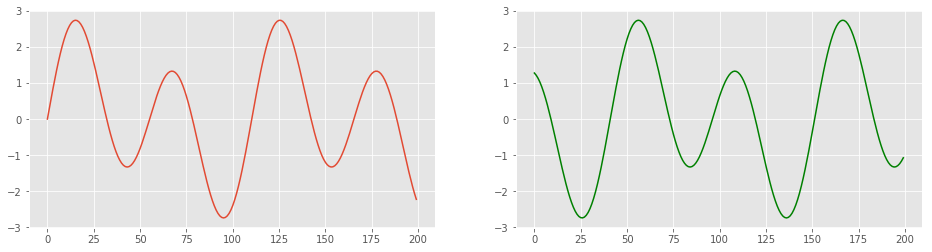

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(train_sequence_1)
ax[1].plot(test_sequence_1, color='green')
plt.show()

In [5]:
train_sequence = train_sequence_1
test_sequence = test_sequence_1

train_sequence = np.reshape(train_sequence, (train_sequence.shape[0], 1))
test_sequence = np.reshape(test_sequence, (test_sequence.shape[0], 1))

In [8]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
min_max_scaler.fit(train_sequence)

scaled_train_sequence = min_max_scaler.transform(train_sequence)
scaled_test_sequence = min_max_scaler.transform(test_sequence)

In [71]:
import warnings
# Supress warning in hmmlearn
warnings.filterwarnings("ignore")


class HMMPredictor(object):
    """
    """
    def __init__(self, data, test_size=0.33, n_hidden_states=2, n_latency_days=10, n_steps_frac_change=50):
        self.data = data
        self.n_latency_days = n_latency_days
        self.hmm = hmm.GaussianHMM(n_components=n_hidden_states)
        self._possible_outcomes = self._train_data = self._test_data = None
        self._split_train_test_data(test_size)
        self._compute_all_possible_outcomes(n_steps_frac_change)

    def _split_train_test_data(self, test_size):
        data = self.data.copy()
        _train_data, _test_data = train_test_split(data, test_size=test_size, shuffle=False)
        self._train_data = _train_data
        self._test_data = _test_data

    @staticmethod
    def _extract_features(data):
        target = np.array(data['target'])
        last = np.array(data['last'])
        frac_change = (target - last) / last
        return frac_change.reshape(-1, 1)

    def fit(self):
        feature_vector = HMMPredictor._extract_features(self._train_data)
        self.hmm.fit(feature_vector)

    def _compute_all_possible_outcomes(self, n_steps_frac_change):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        self._possible_outcomes = np.array(frac_change_range)

    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_start_index:previous_data_end_index]
        previous_data_features = HMMPredictor._extract_features(previous_data)
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(outcome_score)]
        return most_probable_outcome

    def predict_target(self, day_index):
        last = self._test_data.iloc[day_index]['last']
        predicted_frac_change = self._get_most_probable_outcome(day_index)
        return last * (1 + predicted_frac_change)

    def predict_target_for_sequence(self, days, with_plot=False):
        predicted_target = []
        for day_index in tqdm(range(days)):
            predicted_target.append(self.predict_target(day_index))

        if with_plot:
            test_data = self._test_data[0:days].reset_index()
            days = np.array(test_data.index, dtype="datetime64[ms]")
            actual_target = test_data['target']
            # Plot data
            fig = plt.figure()
            axes = fig.add_subplot(111)
            axes.plot(days, actual_target, 'bo-', label="actual")
            axes.plot(days, predicted_target, 'r+-', label="predicted")
            axes.set_title('Predicted vs Actual')
            fig.autofmt_xdate()
            plt.legend()
            plt.show()
        return pd.Series(predicted_target), actual_target


In [72]:
train_df = pd.DataFrame(data=train_sequence, columns=['target'])
train_df['last'] = train_df['target'].shift(1)
train_df = train_df.iloc[2:].copy()
train_df.head()

,target,last
2,0.565813,0.284476
3,0.840912,0.565813
4,1.106750,0.840912
5,1.360422,1.106750
6,1.599168,1.360422


100%|██████████| 60/60 [00:01<00:00, 42.31it/s]


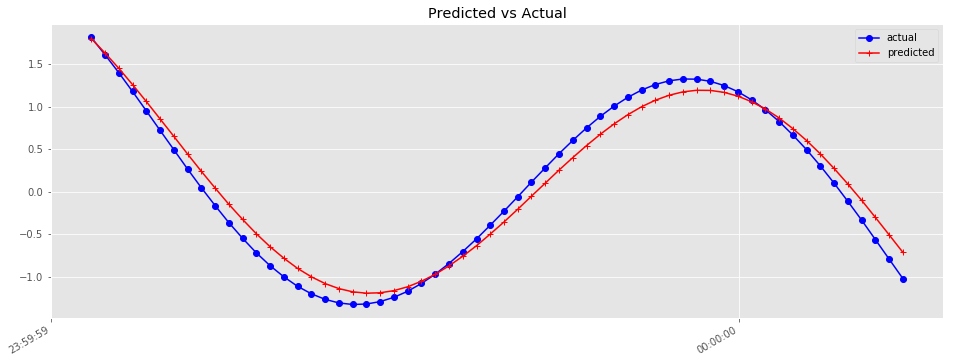

,predicted,actual,accuracy
0,1.801309,1.814076,0.007038
1,1.632668,1.612654,0.012411
2,1.451389,1.399908,0.036774
3,1.259918,1.178672,0.068929
4,1.060805,0.951859,0.114456
5,0.856673,0.722422,0.185835
6,0.650179,0.493316,0.317976
7,0.443985,0.267464,0.659981
8,0.240717,0.047710,4.045418
9,0.042939,-0.163208,-1.263094


In [79]:
hmm_predictor = HMMPredictor(data=train_df)
hmm_predictor.fit()
predicted, actual = hmm_predictor.predict_target_for_sequence(60, with_plot=True)
tdf = pd.DataFrame(data=np.column_stack((predicted, actual)), columns=['predicted', 'actual'])
tdf['accuracy'] = np.abs(tdf['predicted'] - tdf['actual']) / tdf['actual']
tdf